In [1]:
import functions as f
import tokenizer_vars as tv

from Text import *
from LSTM_class import *
import constants as c

from keras import layers, models, optimizers, callbacks
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from transformers import BertTokenizer, GPT2Tokenizer
import pickle
import math

w:\anaconda3\envs\Viver\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
number_of_recipes = c.NUMBER_OF_RECIPES
tokenizer = tv.getTokenizer()

In [3]:
with open(f'data/pickle_files/indices_{number_of_recipes}.pkl', 'rb') as file:
    tokens_ind = pickle.load(file)

In [4]:
number_of_recipes

200000

In [5]:
max_len = 220
step = max_len - 1
batch_size = 32
epochs = 20
rnn_units = 512
learning_rate = 0.001
dropout_rate = 0.3

In [6]:
seq_train = Sequences(tokens_ind, max_len, step)
seq_train.sequences_info()

number of sequences of length 220: 123005


In [7]:
# print(input_train[:500])
# print(text_train.tokens[:50])
# print(text_train.tokens_ind[:50], '\n')

# np.array(seq_train.sequences[:2])

In [8]:
def lstm_model(sequence_length, vocab_size, layer_size):
    model = models.Sequential()
    input_sequence = layers.Input(shape=(None,))
    embedding = layers.Embedding(vocab_size, layer_size)(input_sequence)
    blstm = layers.Bidirectional(layers.LSTM(layer_size, return_sequences=True))(embedding)
    attention = layers.Attention(layer_size)([blstm, blstm])
    dropout = layers.Dropout(dropout_rate)(attention)
    lstm = layers.LSTM(layer_size)(dropout)
    dense = layers.Dense(vocab_size, activation='softmax')(lstm)
    model = models.Model(inputs=input_sequence,outputs=dense)
    
    # model.add(layers.Embedding(vocab_size, layer_size))
    # model.add(layers.Bidirectional(layers.LSTM(layer_size, return_sequences=True)))
    # model.add(layers.Dropout(0.3))
    # model.add(layers.LSTM(layer_size))
    # model.add(layers.Dense(vocab_size, activation='softmax'))
    return model

In [9]:
tokenizer.get_vocab_size()

10013

In [10]:

params_emb = {
    'sequence_length': max_len,
    'vocab_size': tokenizer.get_vocab_size(),
    'batch_size': batch_size,
    'shuffle': True,
    'embedding': True
}

train_generator_emb = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params_emb)

In [11]:
model_emb = lstm_model(max_len, len(tokenizer.get_vocab()), rnn_units)
# optimizer = optimizers.RMSprop(lr=0.001)
optimizer = optimizers.Adam(learning_rate=learning_rate)
model_emb.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_emb.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 1024)   10253312    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 2048)   16785408    ['embedding[0][0]']              
                                                                                                  
 attention (Attention)          (None, None, 2048)   1           ['bidirectional[0][0]',          
                                                                  'bidirectional[0][0]']      

In [12]:
early_stopping_callback = callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [13]:
history = model_emb.fit(
  train_generator_emb,
  steps_per_epoch=len(train_generator_emb),
  epochs=epochs,
  verbose=1,
  callbacks=[
      early_stopping_callback
  ]
)

Epoch 1/20
   6/3843 [..............................] - ETA: 5:01:17 - loss: 7.8855 - accuracy: 0.1562 

KeyboardInterrupt: 

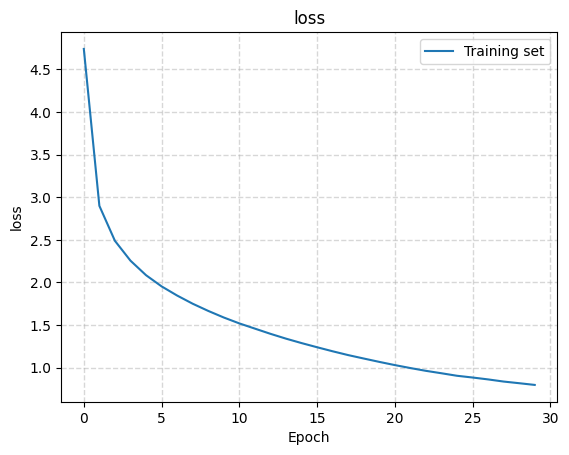

In [ ]:
def render_training_history(training_history, metrics='loss'):
    metrics_history = training_history.history[metrics]

    plt.title(metrics)
    plt.xlabel('Epoch')
    plt.ylabel(metrics)
    plt.plot(metrics_history, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history, 'loss')

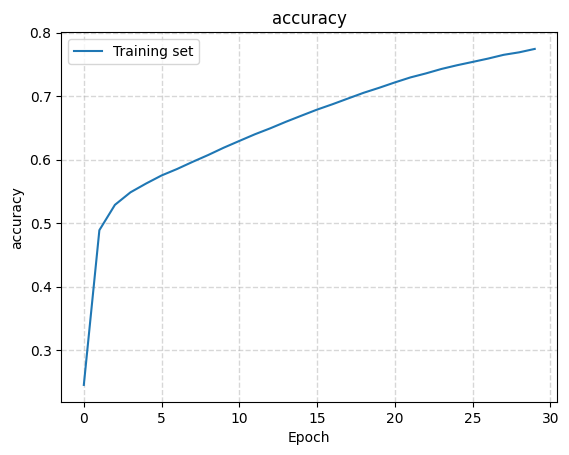

In [ ]:
render_training_history(history, 'accuracy')

In [ ]:
model_emb.save(f'data/out/{number_of_recipes}_seq_{max_len}_batch_{batch_size}_epochs_{epochs}_units_{rnn_units}')

INFO:tensorflow:Assets written to: data/out/200000_seq_120_batch_64_epochs_30_units_512\assets


INFO:tensorflow:Assets written to: data/out/200000_seq_120_batch_64_epochs_30_units_512\assets
